# Change Detection of Buildings from Satellite Imagery

## Table of Contents
* [Introduction](#Introduction)
* [Export training data for deep learning](#Export-training-data-for-deep-learning)
* [Model training](#Model-training)
 * [Necessary imports](#Necessary-imports)
 * [Get training data](#Get-training-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Train the model](#Train-the-model)
 * [Visualize detected changes](#Visualize-detected-changes)
 * [Evaluate model performance](#Evaluate-model-performance)
 * [Save model](#Save-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The World is changing every day and monitoring that change on ground can be a tedious and labor intensive task. so, is there a way to automate it? 

<img width="100%" height="450" loop="loop" controls src="../../static/img/change_14_20.gif" />

This notebook will walk you through how deep learning can be used to perform change detection using satellite images.

One of the popular models available in the `arcgis.learn` module of ArcGIS API for Python, `ChangeDetector` is used to identify areas of persistent change between two different time periods using remotely sensed images. It can help you identify where new buildings have come up for instance. This model is based upon the latest research in deep learning and works well with objects of various sizes.
The `ChangeDetector` model workflow consists of three parts: 
- Preparing the training data, 
- training a model 
- using the trained model for inferencing. 

Let’s first prepare the training data. 

## Export training data for deep learning

In the cells below, we have provided the input rasters and input mask polygons needed to export training data.

In [2]:
from arcgis.gis import GIS
gis = GIS('home')

<Item title:"change_detection_input_rasters" type:Image Collection owner:api_data_owner>
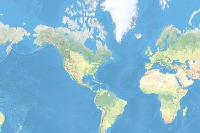

In [17]:
input_data = gis.content.search('change_detection_input_rasters owner: api_data_owner', 'Image Collection')[0]
input_data

In [22]:
mask_polygons = gis.content.search('cd_mask_polygons owner: api_data_owner', 'feature layer')[0]
mask_polygons

<Item title:"cd_input_mask_polygons" type:Feature Layer Collection owner:api_data_owner>

`ChangeDetector` model requires data in following folder format : images, images2 and labels. The 'images' folder has the images before the change and 'images2' folder has the images after the change. The 'label' indicates where there are changes in the before and after images.

The provided input rasters are too large to process in the GPU memory for training the model. We need to create small image chips or tiles from the rasters. Training data can be exported by using the `Export Training Data For Deep Learning tool` available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- Input Raster: 2014rasters
- Additional Raster: 2020rasters
- Input Feature Class: labels
- Tile Size X & Tile Size Y: 256
- Stride X & Stride Y: 64
- Meta Data Format: 'Classified Tiles'
- Environments -> Cell Size: 0.3

<div>
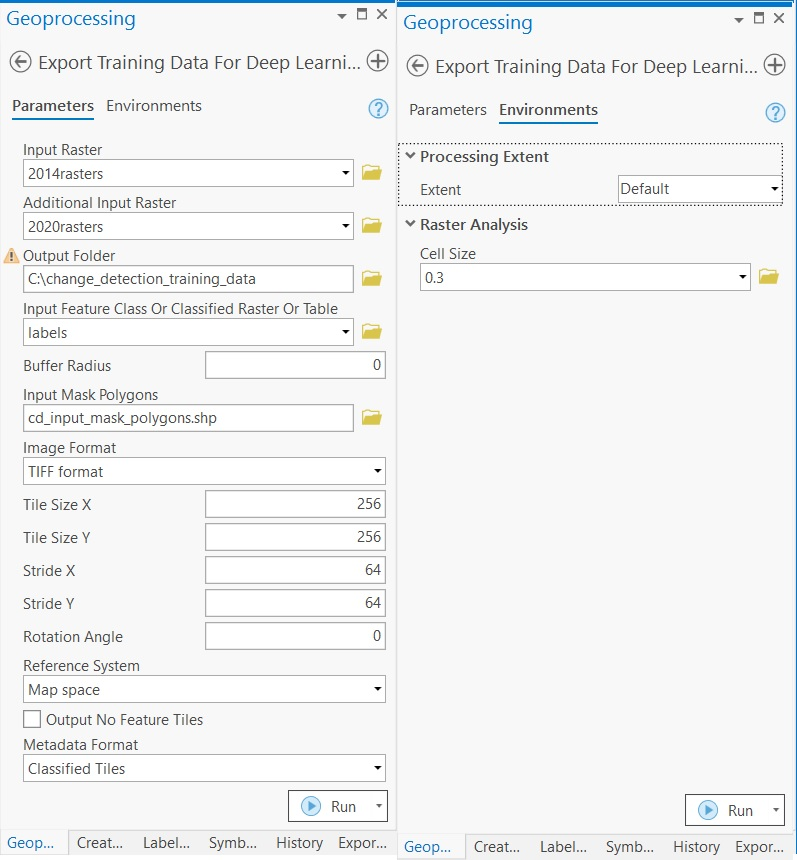
</div>

As shown below, the above tool takes in the input raster and exports them in the required format to creat the training data.

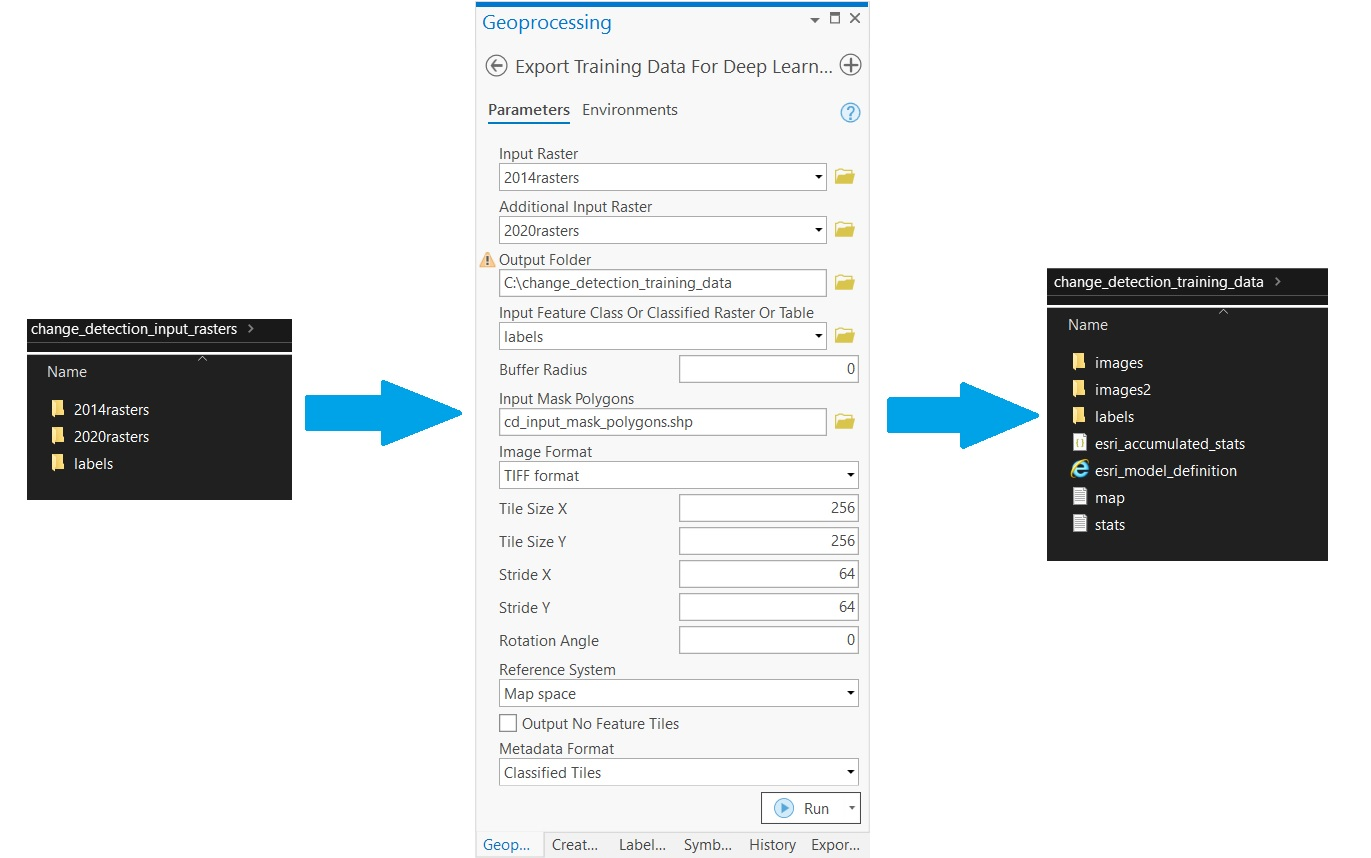

## Model training

This step would be done using jupyter notebook and documentation is available [here](https://developers.arcgis.com/python/guide/install-and-set-up) to install and setup environment.

### Necessary imports

In [3]:
import os
from pathlib import Path
from arcgis.learn import prepare_data, ChangeDetector

### Get training data 

We have already exported the data which can be directly downloaded using the steps below:

<Item title:"change_detection_training_data" type:Image Collection owner:api_data_owner>
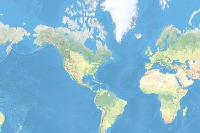

In [4]:
training_data = gis.content.get('d284e2083b254f6b8508f9cf41f53713')
training_data

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

`prepare_data` function takes path to training data and creates a fast.ai databunch with specified transformation, batch size, split percentage, etc.

In [8]:
data = prepare_data(data_path,
                    chip_size=256,
                    dataset_type='ChangeDetection', 
                    batch_size=8
                   )

### Visualize training data

To get a sense of what the training data looks like, use the `show_batch()` method to randomly pick a few training chips and visualize them. The chips are overlaid with masks representing the building footprints in each image chip.

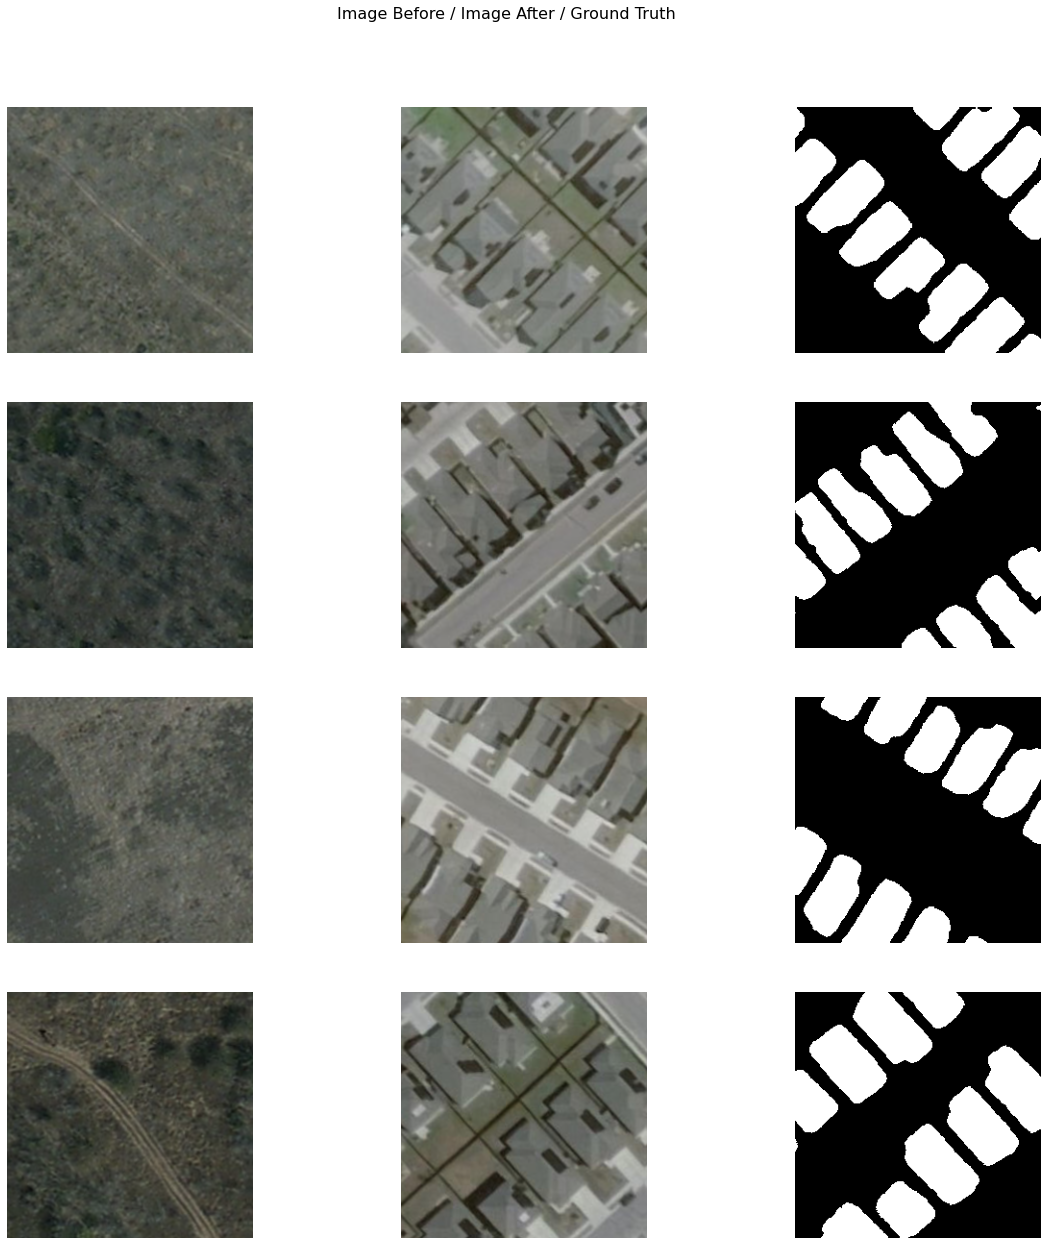

In [4]:
data.show_batch()

### Load model architecture

`arcgis.learn` provides the `ChangeDetector` model for identifying areas of persistent change tasks, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about `ChangeDetector` can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#changedetector).

In [10]:
cd = ChangeDetector(data, backbone='resnet50')

### Train the model

Learning rate is one of the most important hyperparameters in model training. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

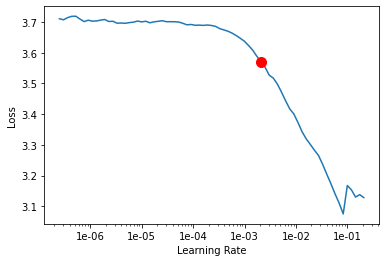

In [11]:
lr = cd.lr_find()

We are using the suggested learning rate above to train the model for 100 epochs.

In [12]:
cd.fit(epochs=100, lr=lr)

We have further trained the model for 100 more epochs to improve model performance. For the sake of time, the cell below is commented out.  

In [ ]:
# cd.fit(100)

### Visualize detected changes

It's a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

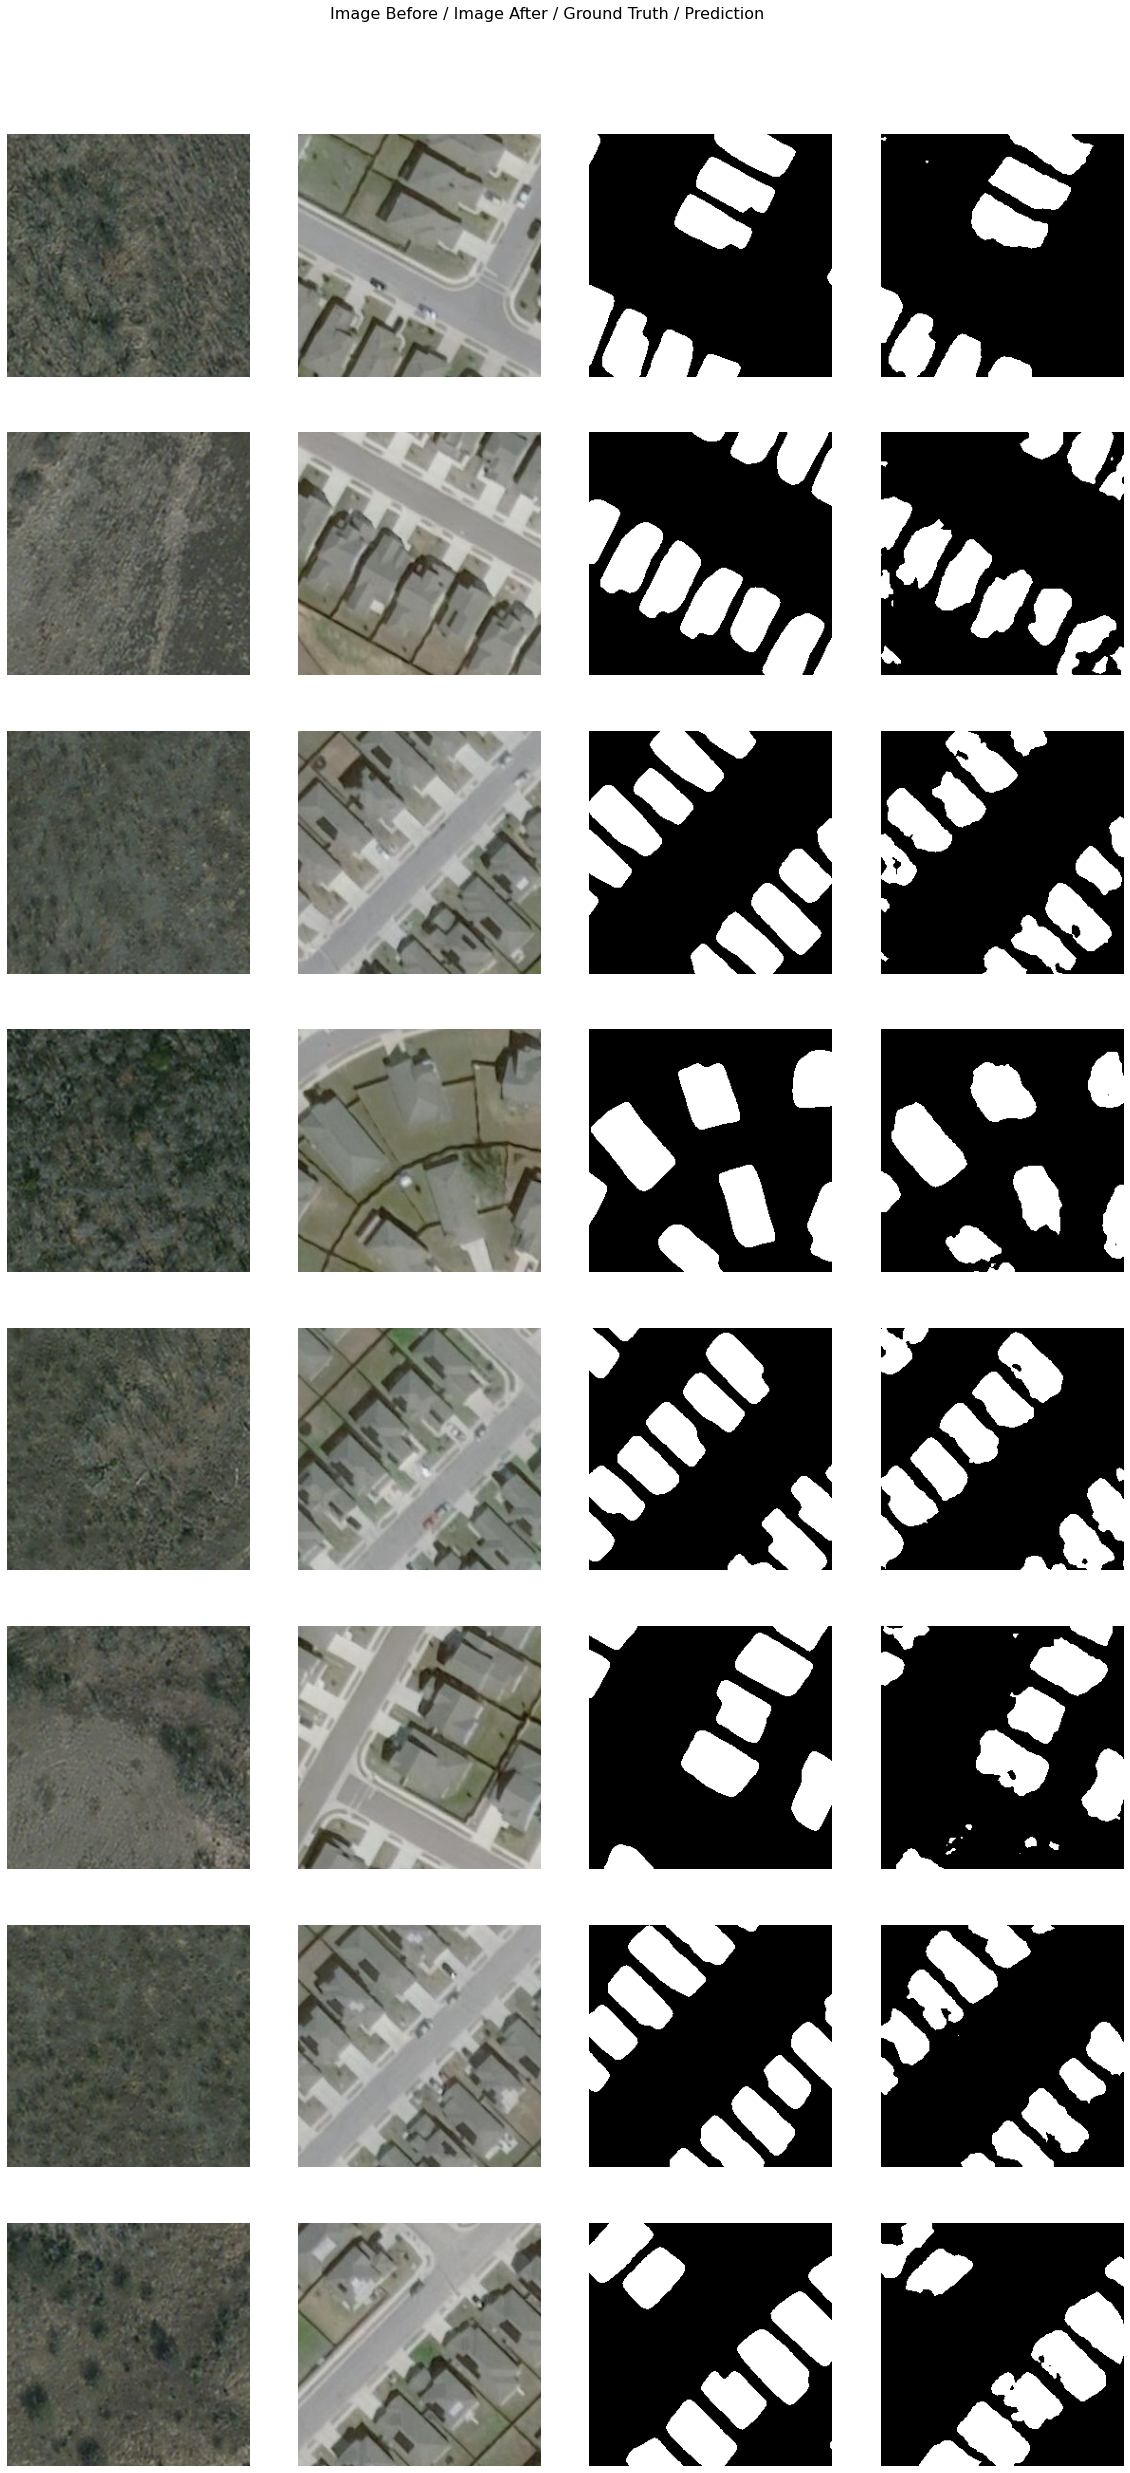

In [17]:
cd.show_results(rows=8) 

### Evaluate model performance

As we have 2 classes for this change detection task, we need to do accuracy assessment for each of those. For that ArcGIS API for Python provides `precision_recall_score` function that will calculate precision and recall for each class.

In [14]:
cd.precision_recall_score()

NoChange    Change
precision  0.936954  0.926067
recall     0.970100  0.848920
f1         0.953147  0.885244

### Save model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
cd.save('change_detection_model_e200')

## Model inference

Using `predict` function, we can apply the trained model on a test image/area to detect changes that occurred in the satellite images during two different time periods. 

<Item title:"cd_inference_data" type:Image Collection owner:api_data_owner>
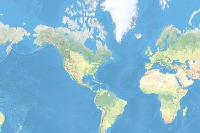

In [19]:
inference_data = gis.content.get('6b32a534228b44b284c14e75b3d3f5f5')
inference_data

In [20]:
test_path = inference_data.download(file_name=inference_data.name)

In [21]:
import zipfile
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(Path(test_path).parent)

In [22]:
test_images = Path(os.path.join(os.path.splitext(test_path)[0]))

In [23]:
before_img = os.path.join(test_images, 'before.tif')
after_img = os.path.join(test_images, 'after.tif')

The predict function takes in before and after image path as required variables. You can optionally pass `visualize=True` if you want to see the results in the notebook. Additionally, you can pass `save=True` function in order to save the image to the local disk.

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

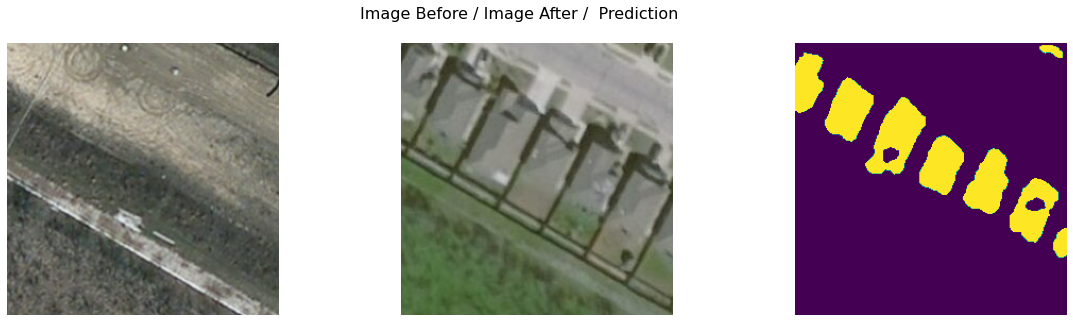

In [24]:
cd.predict(before_image=before_img,
           after_image=after_img,
           visualize=True)

## Model Inference using 'Detect Change Using Deep Learning' tool

We can use the 'Detect Change Using Deep Learning' tool in ArcGIS Pro and ArcGIS Enterprise and infer on a larger area using our trained model.

## Conclusion

In this notebook, we learned how to solve various problems like identifying new construction. The same workflow can also be used to find out which new roads have come up in the past five years for instance. With just some labeled data and with little to no human involvement by using deep learning, we can now perform change detection using satellite images.

## References

- https://developers.arcgis.com/python/sample-notebooks/how_change_detection_works